<a href="https://colab.research.google.com/github/babuus/Identity-and-Emotion-detection/blob/master/Notebook/facial_expressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Collection**

In [ ]:
#uploading Kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"babuus","key":"8d8c3864d8bc1568f7b7841b4a66314d"}'}

In [ ]:
#Download dataset from kaggle
%%bash
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
mkdir ZIP
cd ZIP
kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

mkdir: cannot create directory ‘ZIP’: File exists
100%|##########| 77.3M/77.3M [00:00<00:00, 192MB/s]
100%|##########| 96.6M/96.6M [00:00<00:00, 196MB/s]
100%|##########| 7.01k/7.01k [00:00<00:00, 7.24MB/s]
100%|##########| 92.0M/92.0M [00:00<00:00, 118MB/s] 
100%|##########| 19.3M/19.3M [00:00<00:00, 124MB/s]


# **Facial Expression Recognition**

In [ ]:
# Libraries

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Dense
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
path = '/content/ZIP/'
!unzip "/content/ZIP/icml_face_data.csv.zip" -d "/content/ZIP"

Archive:  /content/ZIP/icml_face_data.csv.zip
  inflating: /content/ZIP/icml_face_data.csv  


## **Reading and Organiing Data**

In [ ]:
# reading the data
data = pd.read_csv("/content/ZIP/icml_face_data.csv")
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
cols = ["emotion","subset","pixels"]
data.columns = cols
data.columns

emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [ ]:
print(data.subset.value_counts())
print(data.emotion.value_counts())

Training       28709
PrivateTest     3589
PublicTest      3589
Name: subset, dtype: int64
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


In [ ]:
# Splitting into train test and validate

train_data = data[data["subset"]=="Training"]
val_data = data[data["subset"]=="PublicTest"]
test_data = data[data["subset"]=="PrivateTest"]

print(train_data.shape,test_data.shape,val_data.shape)

(28709, 3) (3589, 3) (3589, 3)


In [ ]:
# to extract image data from pixel column

def toPixels(pixels):

    arr = np.array(pixels.split(),"float64")
    return arr

def reshapetoImage(data):

    Images = np.reshape(data["pixels"].to_list(),(data.shape[0],48,48,1))

    return Images

In [ ]:
train_data["pixels"] = train_data["pixels"].apply(toPixels)
val_data["pixels"] = val_data["pixels"].apply(toPixels)
test_data["pixels"] = test_data["pixels"].apply(toPixels)

In [ ]:
# images and labels

train_images = reshapetoImage(train_data)
val_images = reshapetoImage(val_data)
test_images = reshapetoImage(test_data)

train_labels = train_data["emotion"]
val_labels = val_data["emotion"]
test_labels = test_data["emotion"]

### **Visualaizing some Images**

In [ ]:
def plotImages(x,y):
    plt.figure(figsize=[20,12])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(x[i],cmap="gray")
        plt.title(emotions[y[i]])
        plt.axis("off")
    plt.show()

In [ ]:
plotImages(train_images,train_labels)

## **Image Data Generator**

In [ ]:
trainGen = Imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
                 )
valGen = Imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
               )
testGen = Imgen(rescale=1./255)

In [ ]:
trainds = trainGen.flow(train_images,train_labels,
                   batch_size = 32
                   )

valds = valGen.flow(val_images,val_labels,
               batch_size = 32
               )

testds = testGen.flow(test_images,test_labels,
                      batch_size=32,
                      shuffle=False)

**One batch**

In [ ]:
# one batch
x,y = next(trainds)

# see 
plotImages(x,y)

## **Model**

In [ ]:
# Model
image_input = Input(shape=(48,48,1))

x = Conv2D(64,(3,3), activation="relu")(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(512,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(512,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(512,activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256,activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

image_output = Dense(7,activation="softmax")(x)

model = Model(image_input,image_output)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 128)       512   

In [ ]:
# Compile the model
print("Compiling the Model....")
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy', metrics=["accuracy"])
print("Model Compiled!")

Compiling the Model....
Model Compiled!


In [ ]:
# Defining callbacks
my_calls = [EarlyStopping(monitor='val_accuracy',patience=5),
            ModelCheckpoint("Model_ethnicity.h5",verbose=1,save_best_only=True)]

**Train**

In [ ]:
hist = model.fit(trainds, epochs=40, validation_data=valds, callbacks=my_calls)

Epoch 1/40
898/898 [==============================] - 45s 16ms/step - loss: 2.4002 - accuracy: 0.2014 - val_loss: 1.6838 - val_accuracy: 0.3675

Epoch 00001: val_loss improved from inf to 1.68382, saving model to Model_ethnicity.h5
Epoch 2/40
898/898 [==============================] - 15s 16ms/step - loss: 1.6459 - accuracy: 0.3578 - val_loss: 1.6433 - val_accuracy: 0.3689

Epoch 00002: val_loss improved from 1.68382 to 1.64329, saving model to Model_ethnicity.h5
Epoch 3/40
898/898 [==============================] - 14s 16ms/step - loss: 1.5041 - accuracy: 0.4174 - val_loss: 1.5048 - val_accuracy: 0.4235

Epoch 00003: val_loss improved from 1.64329 to 1.50477, saving model to Model_ethnicity.h5
Epoch 4/40
898/898 [==============================] - 14s 16ms/step - loss: 1.4214 - accuracy: 0.4555 - val_loss: 1.5279 - val_accuracy: 0.4104

Epoch 00004: val_loss did not improve from 1.50477
Epoch 5/40
898/898 [==============================] - 14s 15ms/step - loss: 1.3720 - accuracy: 0.479

**Test**

In [ ]:
model.evaluate(testds)

113/113 [==============================] - 3s 24ms/step - loss: 0.9962 - accuracy: 0.6317


[0.9962337613105774, 0.631652295589447]

**Graph**

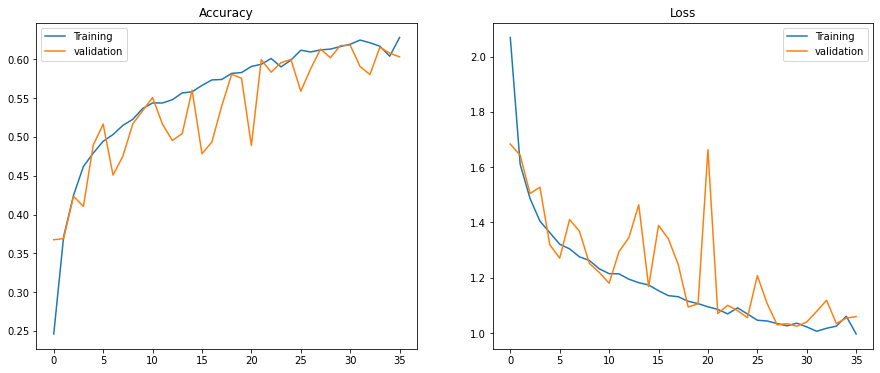

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()


## **Predictions**

In [ ]:
pred = model.predict(testds)

In [ ]:
pred = [np.argmax(i) for i in pred]

In [ ]:
y_test = np.array(test_labels)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.57      0.56      0.56       491
           1       0.61      0.56      0.58        55
           2       0.60      0.29      0.39       528
           3       0.80      0.90      0.85       879
           4       0.57      0.43      0.49       594
           5       0.74      0.76      0.75       416
           6       0.51      0.77      0.61       626

    accuracy                           0.64      3589
   macro avg       0.63      0.61      0.61      3589
weighted avg       0.64      0.64      0.63      3589



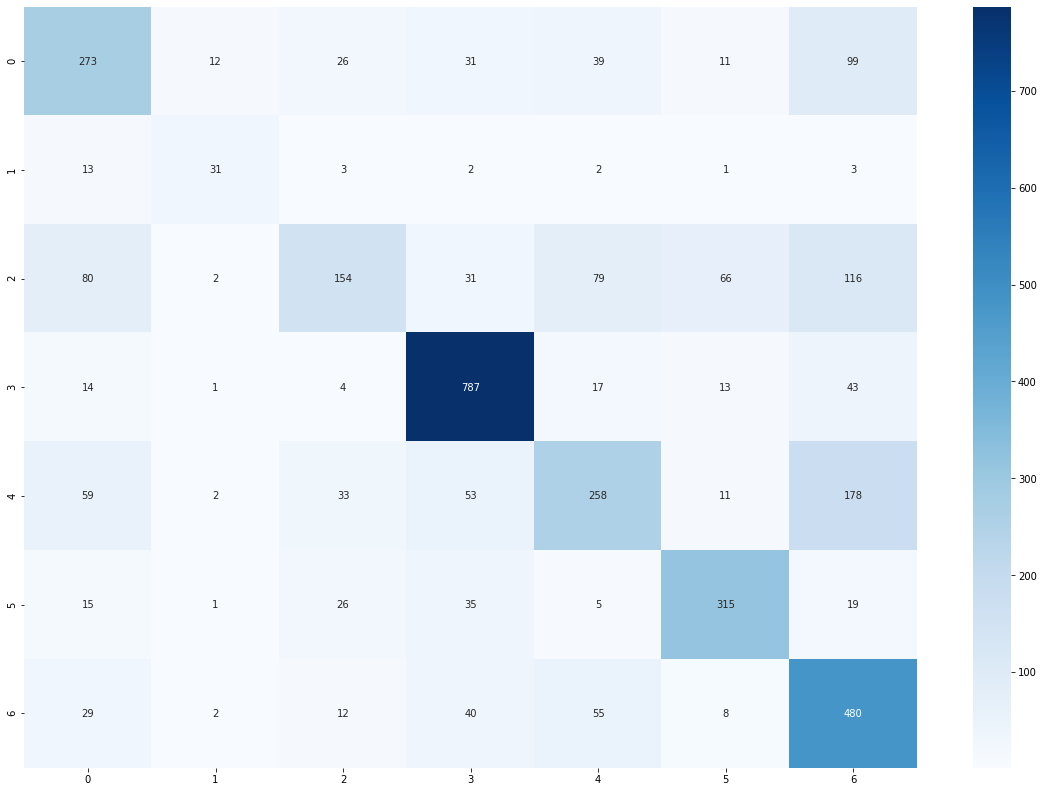

In [ ]:
plt.figure(figsize=[20,14])
sns.heatmap(confusion_matrix(y_test,pred),annot = True, fmt= "d", cmap = "Blues");

In [ ]:
model1 = keras.models.load_model('/content/Model_ethnicity.h5')

In [ ]:
import cv2 as cv
img = cv.imread("/content/pexels-maxime-francis-2246476.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
face = cv.resize(gray, (48,48)) 
face = face/255.0 
face.shape
predictions = model1.predict(np.array([face.reshape((48,48,1))])).argmax()
predictions, emotions[predictions]

(6, 'Neutral')

In [ ]:
testds[0][0].shape

(32, 48, 48, 1)